**0. Kurulum ve Kütüphaneler**

In [111]:
# Hücre 0: Gerekli paketlerin kurulması (Colab için)
!pip install shap optuna -q


In [112]:
# Hücre 1: Kütüphane importları

import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import shap

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)


**1. Veri Setinin Yüklenmesi (Wine)**

In [113]:
# Hücre 2: Wine veri setinin yüklenmesi ve DataFrame oluşturulması

wine = load_wine()

X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")

print("Özellik sayısı:", X.shape[1])
print("Gözlem sayısı:", X.shape[0])
print("\nSınıf isimleri:", wine.target_names)

display(X.head())
print("\nHedef değişken (ilk 10 gözlem):")
print(y.head(10))
print("\nSınıf dağılımı:")
print(y.value_counts().rename(index=dict(enumerate(wine.target_names))))
print("\nSınıf dağılımı (oran):")
print(y.value_counts(normalize=True))


Özellik sayısı: 13
Gözlem sayısı: 178

Sınıf isimleri: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



Hedef değişken (ilk 10 gözlem):
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: target, dtype: int64

Sınıf dağılımı:
target
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64

Sınıf dağılımı (oran):
target
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64


**2. Veri Seti Kalite Kontrolleri**

**2.1 Eksik Değer Analizi**

In [114]:
# Hücre 3: Eksik değer analizi

missing_counts = X.isnull().sum()
print("Her sütundaki eksik değer sayıları:\n", missing_counts)
print("\nToplam eksik değer sayısı:", missing_counts.sum())


Her sütundaki eksik değer sayıları:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

Toplam eksik değer sayısı: 0


**2.2 Aykırı Değer (Outlier) Analizi – Boxplot + IQR**

Her sütundaki aykırı değer sayısı (IQR):
 alcohol                         0
malic_acid                      3
ash                             3
alcalinity_of_ash               4
magnesium                       4
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 2
color_intensity                 4
hue                             1
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


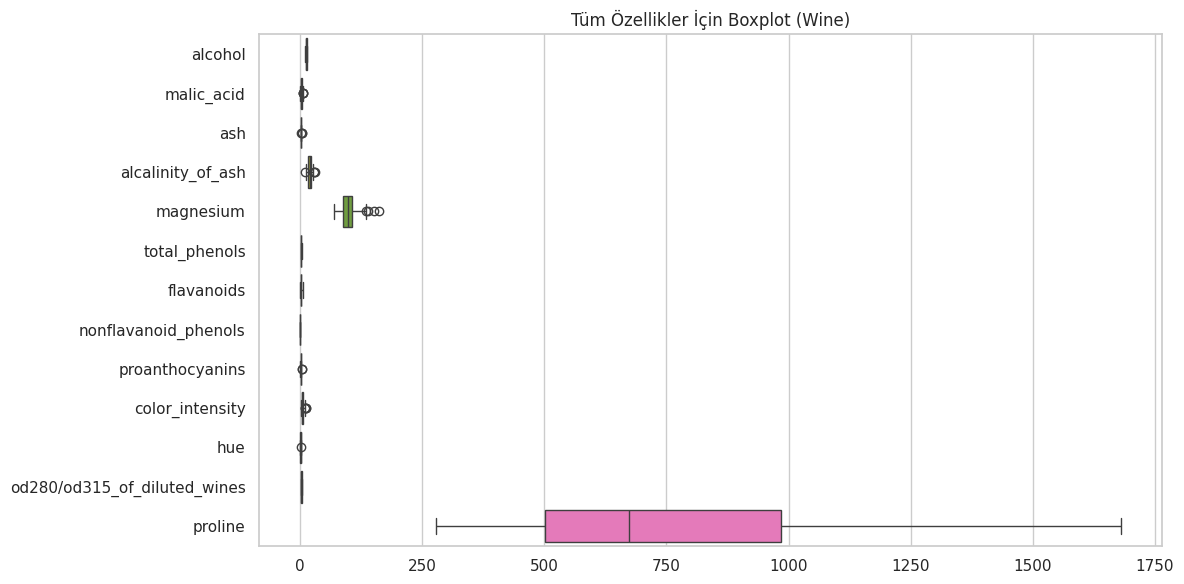

In [115]:
# Hücre 4: IQR yöntemiyle temel aykırı değer analizi

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_flags = (X < lower_bound) | (X > upper_bound)
outlier_counts = outlier_flags.sum()

print("Her sütundaki aykırı değer sayısı (IQR):\n", outlier_counts)

# Boxplot ile görselleştirme
plt.figure(figsize=(12, 6))
sns.boxplot(data=X, orient="h")
plt.title("Tüm Özellikler İçin Boxplot (Wine)")
plt.tight_layout()
plt.show()


**2.3 Veri Tipi ve Dağılım İncelemesi**

In [116]:
# Hücre 5: Veri tipleri ve sayısal/kategorik ayrımı

print("Sütun veri tipleri:\n", X.dtypes)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nSayısal değişken sayısı:", len(num_cols))
print("Kategorik değişken sayısı:", len(cat_cols))


Sütun veri tipleri:
 alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

Sayısal değişken sayısı: 13
Kategorik değişken sayısı: 0


**3. Keşifsel Veri Analizi (EDA)**

**3.1 İstatistiksel Özellikler**

In [117]:
# Hücre 6: Temel istatistiksel özetler

desc = X.describe().T  # mean, std, min, 25%, 50%, 75%
desc["median"] = X.median()
desc["Q1"] = X.quantile(0.25)
desc["Q3"] = X.quantile(0.75)
display(desc)


,count,mean,std,min,25%,50%,75%,max,median,Q1,Q3
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83,13.050,12.3625,13.6775
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80,1.865,1.6025,3.0825
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23,2.360,2.2100,2.5575
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00,19.500,17.2000,21.5000
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00,98.000,88.0000,107.0000
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88,2.355,1.7425,2.8000
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08,2.135,1.2050,2.8750
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66,0.340,0.2700,0.4375
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58,1.555,1.2500,1.9500
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00,4.690,3.2200,6.2000


**3.2 Korelasyon Matrisi ve Heatmap**

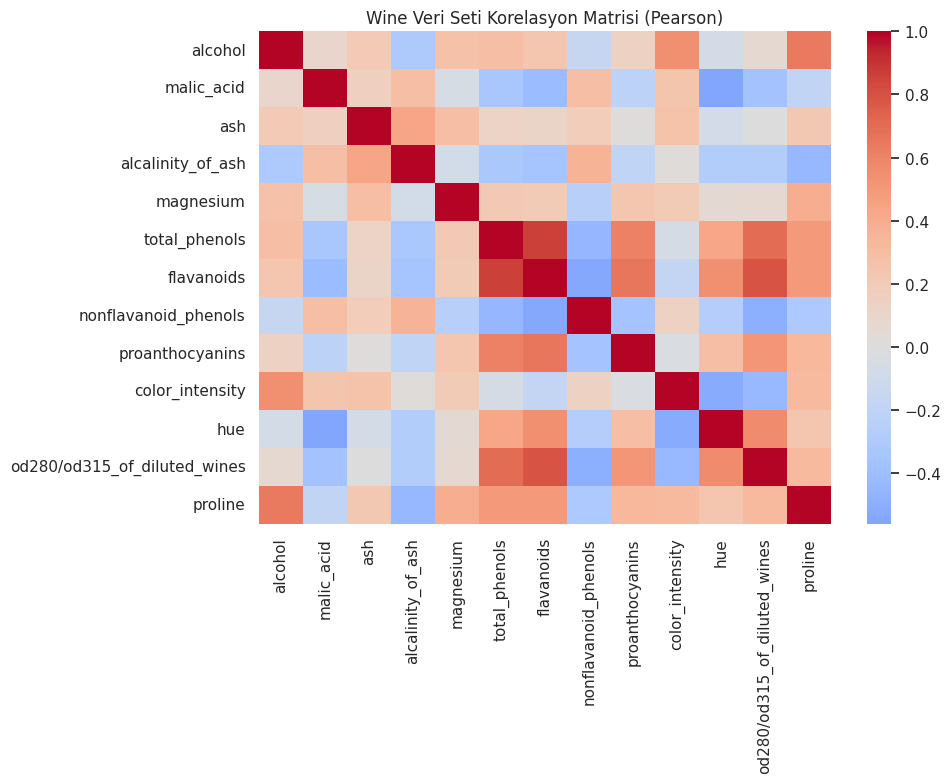

En yüksek korelasyonlu 3 çift:

total_phenols - flavanoids: korelasyon = 0.865
od280/od315_of_diluted_wines - flavanoids: korelasyon = 0.787
total_phenols - od280/od315_of_diluted_wines: korelasyon = 0.700


In [118]:
# Hücre 7: Korelasyon matrisi ve heatmap

corr = X.corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Wine Veri Seti Korelasyon Matrisi (Pearson)")
plt.tight_layout()
plt.show()

# En yüksek korelasyonlu 3 çift (mutlak değere göre)
corr_unstack = corr.unstack()
corr_unstack = corr_unstack[corr_unstack.index.get_level_values(0) != corr_unstack.index.get_level_values(1)]
corr_unstack = corr_unstack.abs().sort_values(ascending=False)

top3 = corr_unstack.groupby(level=0).head(3).drop_duplicates().head(3)
print("En yüksek korelasyonlu 3 çift:\n")
for (f1, f2), val in top3.items():
    print(f"{f1} - {f2}: korelasyon = {corr.loc[f1, f2]:.3f}")


**3.3 Boxplot Analizi**

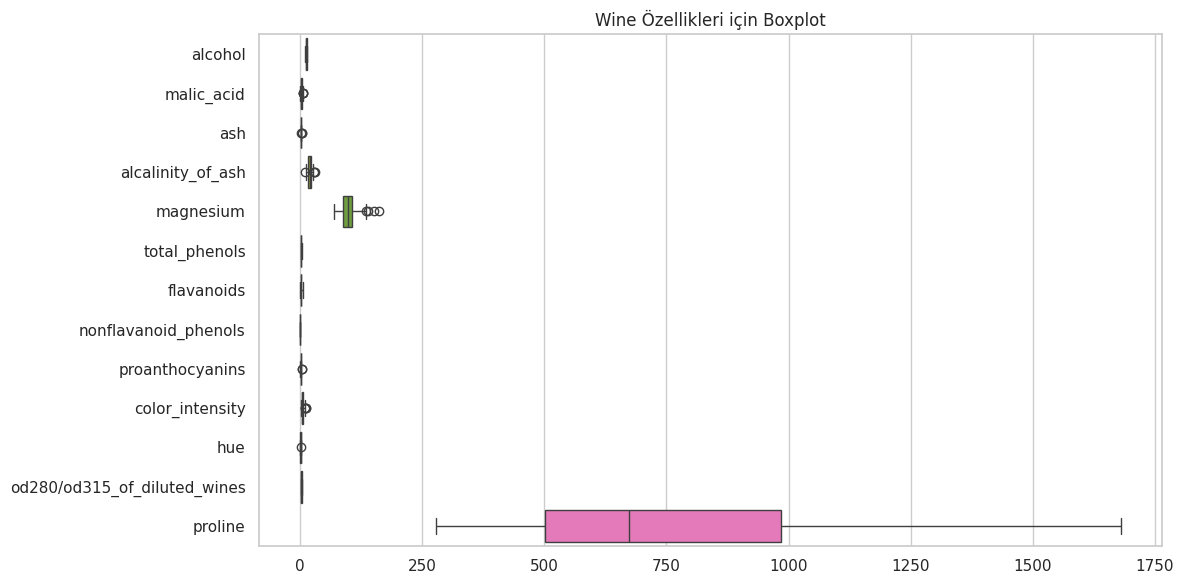

In [119]:
# Hücre 8: Tüm özellikler için boxplot

plt.figure(figsize=(12, 6))
sns.boxplot(data=X, orient="h")
plt.title("Wine Özellikleri için Boxplot")
plt.tight_layout()
plt.show()


**4. Veri Setinin Bölünmesi (70 / 10 / 20)**

In [120]:
# Hücre 9: Veri setinin train / validation / test olarak bölünmesi

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)  # 70% train, 30% temp

# temp'i validation (10%) ve test (20%) olacak şekilde böl
val_size = 0.3333  # 0.3333 * 0.3 ≈ 0.1
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(2/3), random_state=42, stratify=y_temp
)

print("Train boyutu:", X_train.shape[0])
print("Validation boyutu:", X_val.shape[0])
print("Test boyutu:", X_test.shape[0])


Train boyutu: 124
Validation boyutu: 18
Test boyutu: 36


**5. Veri Ölçeklendirme (StandardScaler)**

In [121]:
# Hücre 10: StandardScaler ile ölçeklendirme

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Tüm veri için istenirse:
X_scaled = scaler.transform(X)

feature_names = X.columns

print("Ölçeklendirme tamamlandı.")


Ölçeklendirme tamamlandı.


**6. Farklı MLP Modellerinin Kurulması**

In [122]:
models = {
    "1 Model_Basit": MLPClassifier(
        hidden_layer_sizes=(16,),
        activation="relu",
        learning_rate_init=0.001,
        solver="sgd",
        momentum=0.2,
        batch_size=8,
        alpha=0.05,
        early_stopping=True,
        validation_fraction=0.3,
        max_iter=300,
        random_state=42
    ),

    "2 Model_Orta": MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        learning_rate_init=0.005,
        solver="sgd",
        momentum=0.2,
        batch_size=8,
        alpha=0.05,
        early_stopping=True,
        validation_fraction=0.3,
        max_iter=300,
        random_state=42
    ),

    "3 Model_Genis": MLPClassifier(
        hidden_layer_sizes=(64, 64),
        activation="tanh",
        learning_rate_init=0.001,
        solver="sgd",
        momentum=0.2,
        batch_size=8,
        alpha=0.05,
        early_stopping=True,
        validation_fraction=0.3,
        max_iter=300,
        random_state=42
    ),

    "4 Model_Derin": MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        learning_rate_init=0.0005,
        solver="sgd",
        momentum=0.2,
        batch_size=8,
        alpha=0.05,
        early_stopping=True,
        validation_fraction=0.3,
        max_iter=300,
        random_state=42
    ),

    "5 Model_DusukLR": MLPClassifier(
        hidden_layer_sizes=(32,),
        activation="relu",
        learning_rate_init=0.0001,
        solver="sgd",
        momentum=0.2,
        batch_size=8,
        alpha=0.05,
        early_stopping=True,
        validation_fraction=0.3,
        max_iter=300,
        random_state=42
    )
}


**7.Validation Performanslarının Ölçülmesi**

In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

for name, model in models.items():

    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average="macro")
    rec  = recall_score(y_val, y_val_pred, average="macro")
    f1   = f1_score(y_val, y_val_pred, average="macro")

    # ✔ DOĞRU ROC-AUC (çok sınıflı problem için)
    roc_auc = roc_auc_score(y_val, y_val_proba, multi_class="ovr")

    results.append([
        name, acc, prec, rec, f1, roc_auc
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision_macro", "Recall_macro", "F1_macro", "ROC_AUC"]
)

results_df


,Model,Accuracy,Precision_macro,Recall_macro,F1_macro,ROC_AUC
0,1 Model_Basit,0.833333,0.833333,0.849206,0.837218,0.884440
1,2 Model_Orta,0.944444,0.944444,0.952381,0.944056,0.994872
2,3 Model_Genis,0.888889,0.885714,0.885714,0.885714,0.976757
3,4 Model_Derin,0.833333,0.900000,0.811111,0.827540,0.968099
4,5 Model_DusukLR,0.555556,0.661376,0.553968,0.555556,0.759795


**8. En İyi Modelin Test Performansı**

Bu tabloya göre Validation’daki en iyi model:

2 Model_Orta

(Accuracy = 0.9444, F1 = 0.9440, ROC-AUC = 0.9948)

**8.1 Test Performans Metrikleri**

In [124]:
best_model = models["2 Model_Orta"]
best_model.fit(X_train_scaled, y_train)

y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)

test_acc  = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average="macro")
test_rec  = recall_score(y_test, y_test_pred, average="macro")
test_f1   = f1_score(y_test, y_test_pred, average="macro")
test_auc  = roc_auc_score(y_test, y_test_proba, multi_class="ovr")

print("TEST SETİ PERFORMANSI:")
print("Accuracy :", test_acc)
print("Precision:", test_prec)
print("Recall   :", test_rec)
print("F1-score :", test_f1)
print("ROC-AUC  :", test_auc)


TEST SETİ PERFORMANSI:
Accuracy : 0.8888888888888888
Precision: 0.903030303030303
Recall   : 0.9047619047619048
F1-score : 0.8915343915343916
ROC-AUC  : 0.9901094276094277


**8.2 Confusion Matrix (seaborn heatmap)**

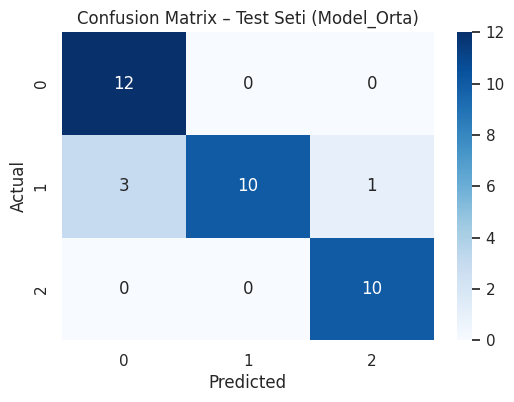

In [125]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix – Test Seti (Model_Orta)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**8.3 ROC Eğrisi (3 sınıf için ayrı ayrı – OVR)**

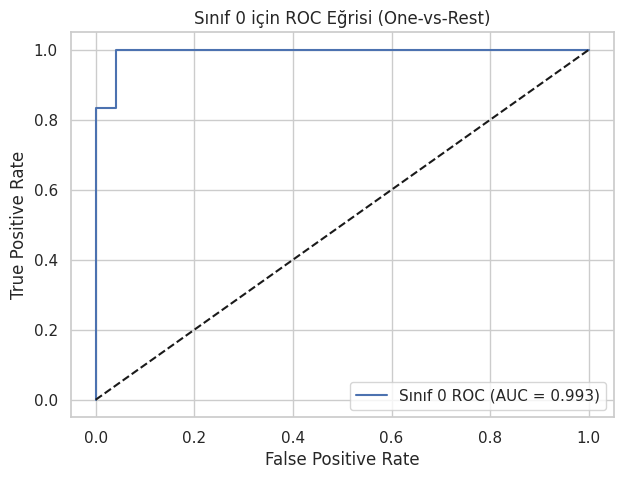

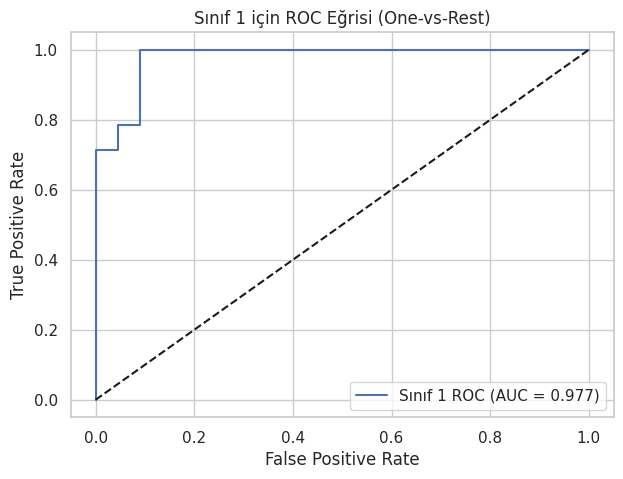

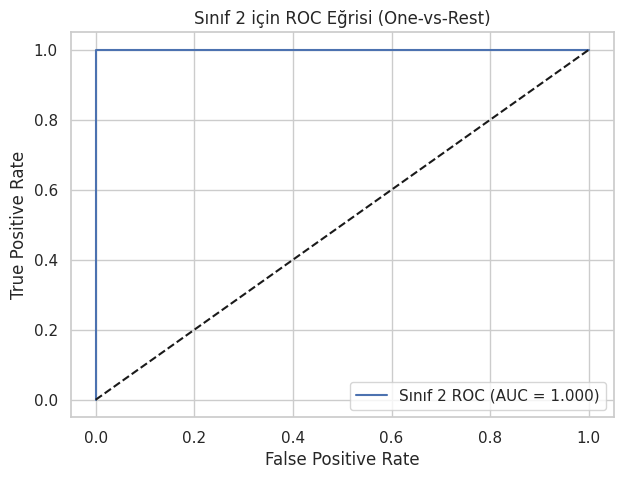

In [126]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

# One-vs-Rest için binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Tek tek ROC grafikleri
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    auc_val = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"Sınıf {i} ROC (AUC = {auc_val:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Sınıf {i} için ROC Eğrisi (One-vs-Rest)")
    plt.legend()
    plt.show()


**9. Optuna Hiperparametre Optimizasyonu**

**9.1 Optuna Study Tanımı**

In [127]:
import optuna

def objective(trial):
    h1 = trial.suggest_int("h1", 16, 256)
    h2 = trial.suggest_int("h2", 8, 128)

    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) # Updated from suggest_loguniform
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True) # Updated from suggest_loguniform
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch = trial.suggest_categorical("batch", [16, 32, 64, 128])

    model = MLPClassifier(
        hidden_layer_sizes=(h1, h2),
        activation=activation,
        learning_rate_init=lr,
        alpha=alpha,
        solver=solver,
        batch_size=batch,
        max_iter=300,
        early_stopping=True,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_val_scaled)
    f1 = f1_score(y_val, pred, average="macro")
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

[I 2025-11-25 20:51:57,732] A new study created in memory with name: no-name-f8e495a5-f0b2-4b3c-a301-800e60180316
[I 2025-11-25 20:51:58,080] Trial 0 finished with value: 0.8222222222222223 and parameters: {'h1': 223, 'h2': 73, 'activation': 'relu', 'lr': 0.0001698978802885052, 'alpha': 8.078008687328231e-05, 'solver': 'adam', 'batch': 64}. Best is trial 0 with value: 0.8222222222222223.
[I 2025-11-25 20:51:58,200] Trial 1 finished with value: 0.7282051282051283 and parameters: {'h1': 58, 'h2': 109, 'activation': 'relu', 'lr': 0.00036247766295748426, 'alpha': 0.004208286723565156, 'solver': 'adam', 'batch': 32}. Best is trial 0 with value: 0.8222222222222223.
[I 2025-11-25 20:51:58,285] Trial 2 finished with value: 0.9474747474747475 and parameters: {'h1': 132, 'h2': 21, 'activation': 'relu', 'lr': 0.0026497026185351084, 'alpha': 0.0011417119958661139, 'solver': 'sgd', 'batch': 32}. Best is trial 2 with value: 0.9474747474747475.
/usr/local/lib/python3.12/dist-packages/sklearn/neural_n

**9.4 En iyi Optuna Trial’ın Raporlanması**

In [128]:
print("En iyi trial:")
best_trial = study.best_trial

for k, v in best_trial.params.items():
    print(k, ":", v)

print("\nEn İyi Modelin Validation F1 Skoru =", best_trial.value)


En iyi trial:
h1 : 120
h2 : 40
activation : relu
lr : 0.0014399639187910492
alpha : 0.003456380146970393
solver : adam
batch : 128

En İyi Modelin Validation F1 Skoru = 1.0


**10. XAI – SHAP Açıklanabilirlik Analizi**

Bu bölümde Wine veri seti üzerinde eğitilen modellerin karar mekanizması SHAP yöntemi ile açıklanmıştır. SHAP (SHapley Additive exPlanations) her özelliğin modele yaptığı pozitif/negatif katkıyı sayısal olarak gösteren bir yöntemdir.

Analiz iki model üzerinde yapılmıştır:

1. En iyi MLP modeli (Model_Orta)

2. Optuna ile bulunan en iyi model

**10.1 – En İyi MLP Modeli (Model_Orta) İçin SHAP Analizi**

En iyi model validasyon sonuçlarına göre Model_Orta olarak belirlenmiştir.

**10.1.1 – SHAP Explainer’ın Kurulması**

In [129]:
import shap
shap.initjs()

# Güvenli örnek seçimi (sample hatası olmasın diye)
bg_size   = min(40, len(X_train_scaled))
val_size  = min(50, len(X_val_scaled))

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_df   = pd.DataFrame(X_val_scaled,   columns=X.columns)

background = X_train_df.sample(bg_size, random_state=0)
val_sample = X_val_df.sample(val_size, random_state=1)

# Çok sınıflı SHAP
explainer_mlp = shap.KernelExplainer(best_model.predict_proba, background)
shap_values_mlp = explainer_mlp.shap_values(val_sample, nsamples=50)


  0%|          | 0/18 [00:00<?, ?it/s]

**10.1.2 Summary Plot**

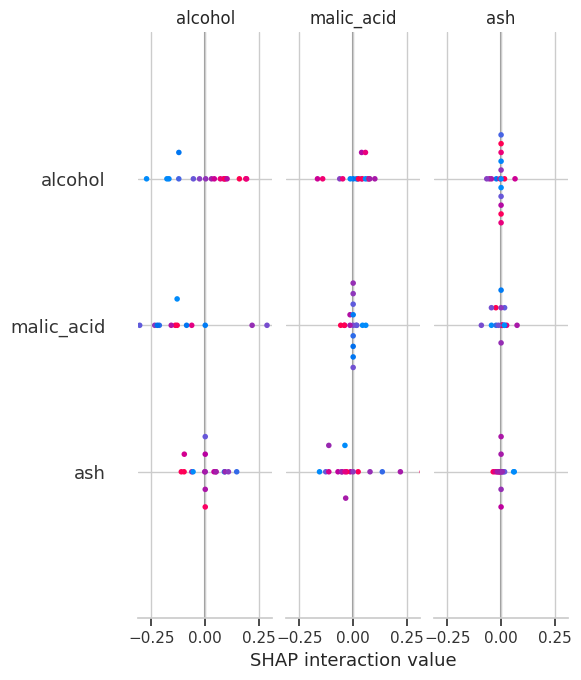

<Figure size 1000x600 with 0 Axes>

In [130]:
import matplotlib.pyplot as plt

# Mevcut figure boyutunu geçici olarak GitHub için daha uygun bir değere ayarla
original_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (10, 6) # Daha küçük bir boyut belirle

# SHAP summary plot'u oluştur
shap.summary_plot(shap_values_mlp, val_sample, feature_names=X.columns)

# Grafiği GitHub için optimize edilmiş bir boyutta ve çözünürlükte kaydet
plt.savefig("shap_summary_plot_optimized.png", dpi=150, bbox_inches='tight')

# Eski figure boyutunu geri yükle (eğer başka grafikler etkilenmesin isteniyorsa)
plt.rcParams["figure.figsize"] = original_figsize

plt.show() # Grafiği notebook'ta da göster

**10.1.3 Bar Plot**

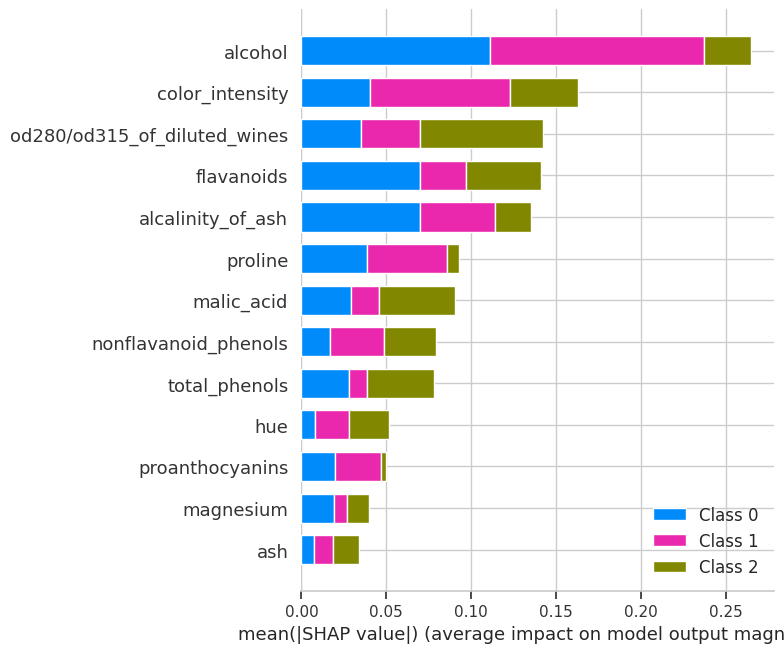

In [140]:
shap.summary_plot(shap_values_mlp, val_sample, feature_names=X.columns, plot_type="bar")


**10.2 – Optuna En İyi Model İçin SHAP Analizi**

Aşağıda Optuna’nın bulduğu en iyi MLP modeli için dört SHAP görselleştirmesi hazırlanmıştır:

summary_plot

bar_plot

force_plot

decision_plot

Ardından elde edilen sonuçlar yorumlanmıştır.

**Best Optuna Model Tanımlama**

In [132]:
# Parametreleri al
best_params = study.best_params
print("Optuna En İyi Parametreler:", best_params)

# Gizli katman yapısı: h1 ve h2
hidden = (best_params["h1"], best_params["h2"])

# Model oluştur
best_optuna_model = MLPClassifier(
    hidden_layer_sizes = hidden,
    learning_rate_init = best_params["lr"],
    alpha = best_params["alpha"],
    activation = best_params["activation"],
    solver = best_params["solver"],
    batch_size = best_params["batch"],
    max_iter = 300,
    random_state = 0
)

# Modeli eğit
best_optuna_model.fit(X_train_scaled, y_train)

print("\nbest_optuna_model başarıyla oluşturuldu ve eğitildi.")


Optuna En İyi Parametreler: {'h1': 120, 'h2': 40, 'activation': 'relu', 'lr': 0.0014399639187910492, 'alpha': 0.003456380146970393, 'solver': 'adam', 'batch': 128}

best_optuna_model başarıyla oluşturuldu ve eğitildi.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


**1. SHAP summary_plot (dots)**

  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.077e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.704e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.680e-04, with an active set of 9 regressors, and the smallest cholesky pivot element being 2

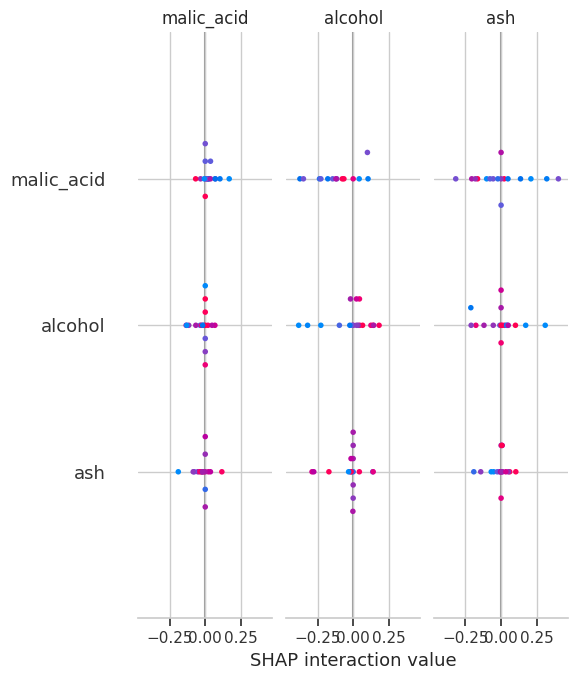

In [139]:
import shap
import pandas as pd
shap.initjs()

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_df   = pd.DataFrame(X_val_scaled,   columns=X.columns)

background_opt = X_train_df.sample(min(20, len(X_train_df)), random_state=0)
val_sample_opt = X_val_df.sample(min(20, len(X_val_df)), random_state=1)

explainer_opt = shap.KernelExplainer(best_optuna_model.predict_proba, background_opt)
shap_values_opt = explainer_opt.shap_values(val_sample_opt, nsamples=30)

shap.summary_plot(shap_values_opt, val_sample_opt, feature_names=X.columns)


**2. SHAP Bar Plot**

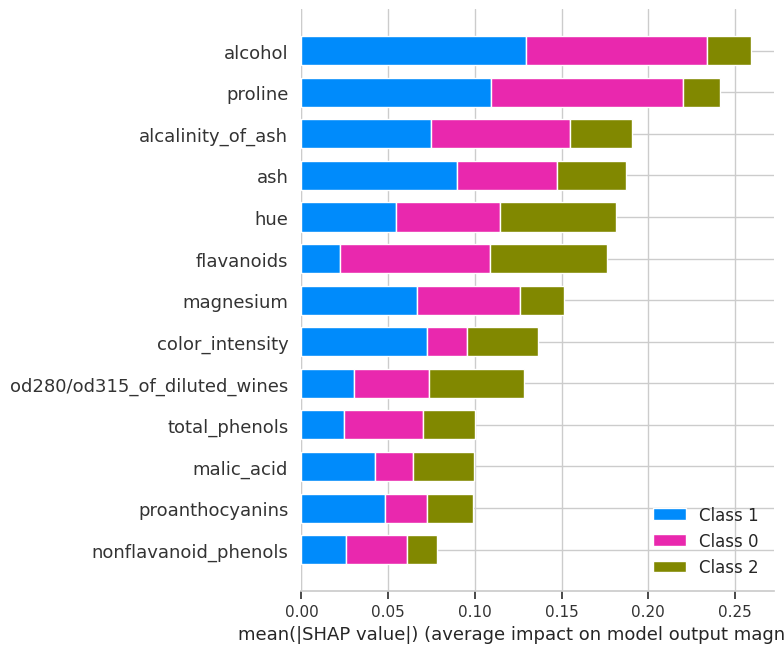

In [134]:
import shap
shap.initjs()

# SHAP bar plot
shap.summary_plot(shap_values_opt, val_sample_opt,
                  feature_names=X.columns,
                  plot_type="bar")


**3. SHAP Force Plot**

  0%|          | 0/1 [00:00<?, ?it/s]

x_force shape: (13,)
shap_vec shape: (13,)


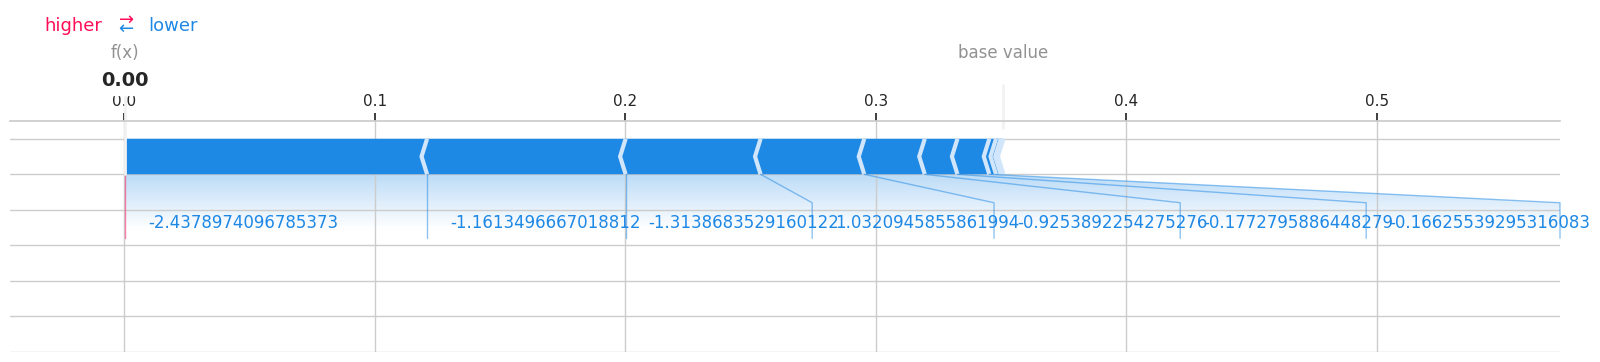

In [137]:
import shap
shap.initjs()

# 1) Tek sınıf olasılığı döndüren fonksiyon
def predict_class1(X):
    return binary_model_opt.predict_proba(X)[:,1]

# 2) Yeni SHAP açıklayıcı
explainer_force = shap.KernelExplainer(predict_class1, background_opt)

# 3) Tek örnek SHAP değerleri
shap_vec = explainer_force.shap_values(row_opt, nsamples=50)[0]

# 4) NumPy flatten
x_force = row_opt.values.flatten()
shap_vec = np.array(shap_vec).flatten()

print("x_force shape:", x_force.shape)
print("shap_vec shape:", shap_vec.shape)

# 5) Force plot
shap.force_plot(
    explainer_force.expected_value,
    shap_vec,
    x_force,
    matplotlib=True
)


**4. SHAP Decision Plot**

In [138]:
import shap
import numpy as np

shap.initjs()

# 1) Tek sınıf olasılığı döndüren fonksiyon
def predict_class1(X):
    return binary_model_opt.predict_proba(X)[:,1]

# 2) Decision plot için yeni SHAP açıklayıcı
explainer_decision = shap.KernelExplainer(predict_class1, background_opt)

# 3) Tek örnek SHAP değerleri
shap_vec_decision = explainer_decision.shap_values(row_opt, nsamples=50)

# 4) Flatten işlemi
shap_vec_decision = np.array(shap_vec_decision).flatten()           # (13,)
x_row = row_opt.values.flatten()                                    # (13,)

print("SHAP decision vector shape:", shap_vec_decision)


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP decision vector shape: [ 0.         -0.02217177 -0.09987019  0.          0.00920889 -0.03846471
  0.         -0.06932024 -0.01604118 -0.00098579 -0.00024272 -0.02668344
 -0.08601929]
